Some facts:
- infections with symptoms roughly 50% of all infections https://www.nature.com/articles/d41586-020-00822-x

In [418]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re

## Building the data

In [419]:
tot_pops = {'Bayern': 13076721,
            'Schleswig-Holstein': 2896712,
            'Hamburg': 1841179,
            'Bremen': 82986,
            'Nordrhein-Westfalen': 17932651,
            'Hessen': 6265809,
            'Rheinland-Pfalz': 4084844,
            'Baden-Württemberg': 11069533,
            'Saarland': 990509,
            'Berlin': 3644826,
            'Mecklenburg-Vorpommern': 1609675,
            'Sachsen': 4077937,
            'Sachsen-Anhalt': 2208321,
            'Thüringen': 2143145,
            'Niedersachsen': 7963000,
            'Brandenburg': 2504000,
           }

Read aggregated data fro BL/age/sex

In [420]:
LK_df = pd.read_csv("daily_corona_data/aggregate_landeskreis_G_AG.csv", index_col=0)
LK_df.Meldedatum = LK_df.Meldedatum.transform(lambda x: datetime.datetime.strptime(re.sub("T.*", "", x), "%Y-%m-%d"))
LK_df.Landkreis = LK_df.Landkreis.transform(lambda x: re.sub(".K ", "", x))
LK_df.head()

,Meldedatum,Landkreis,Geschlecht,Altersgruppe,AnzahlFall,AnzahlTodesfall,TotalAnzahl_BL_G_AG,TotalDeath_BL_G_AG
0,2020-01-28,Landsberg a.Lech,M,A15-A34,1,0,1,0
4858,2020-03-17,Landsberg a.Lech,M,A15-A34,1,0,2,0
2998,2020-03-14,Landsberg a.Lech,M,A35-A59,1,0,1,0
5963,2020-03-18,Landsberg a.Lech,M,A35-A59,2,0,3,0
7038,2020-03-19,Landsberg a.Lech,M,A35-A59,1,0,4,0


How many BL? How many age groups?

In [421]:
age_groups = LK_df.Altersgruppe.unique()
age_groups = age_groups[age_groups != "unbekannt"]
n_age_groups = len(age_groups)
age_groups

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A00-A04', 'A05-A14'],
      dtype=object)

In [422]:
LKs = LK_df.Landkreis.unique()
LKs = LKs[LKs != "-nicht erhoben-"]
n_LKs = len(LKs)
LKs

array(['Landsberg a.Lech', 'Starnberg', 'Fürstenfeldbruck', 'München',
       'Traunstein', 'Delmenhorst', 'Freising', 'Göppingen', 'Tübingen',
       'Breisgau-Hochschwarzwald', 'Esslingen', 'Heinsberg', 'Rottweil',
       'Freiburg i.Breisgau', 'Böblingen', 'Ludwigsburg', 'Viersen',
       'Erlangen', 'Gießen', 'Heilbronn', 'Märkischer Kreis',
       'Rhein-Neckar-Kreis', 'Segeberg', 'Wesel', 'Bonn', 'Fürth',
       'Kaiserslautern', 'StadtRegion Aachen', 'Ostallgäu', 'Hamburg',
       'Köln', 'Lübeck', 'Düren', 'Groß-Gerau', 'Lahn-Dill-Kreis',
       'Oberhavel', 'Region Hannover', 'Bremen', 'Duisburg', 'Münster',
       'Schwabach', 'Borken', 'Cuxhaven', 'Ebersberg',
       'Herzogtum Lauenburg', 'Hochtaunuskreis', 'Rhein-Kreis Neuss',
       'Rheinisch-Bergischer Kreis', 'Sächsische Schweiz-Osterzgebirge',
       'Zollernalbkreis', 'Essen', 'Frankfurt am Main', 'Mannheim',
       'Nürnberg', 'Ammerland', 'Bergstraße', 'Karlsruhe', 'Lörrach',
       'Main-Kinzig-Kreis', 'Oberbergis

Pick numbers from last week

In [423]:
today = LK_df.Meldedatum.sort_values().iloc[-1]
last_week = today - datetime.timedelta(days=7)
last_week

Timestamp('2020-03-13 00:00:00')

Load commute values

In [424]:
def namechange(x):
    x = re.sub(r"(?<!\w)im ", "i.", x)
    x = re.sub(r"(?<!\w)am ", "a.", x)
    x = re.sub("an der ", "a.d.", x)
    x = re.sub("in der ", "i.d.", x)    
    return x

In [425]:
comm_df = pd.read_csv("commute_data/Commuting.csv", index_col=0)
comm_df = comm_df.rename({el: namechange(el) for el in comm_df.index.values})
comm_df = comm_df.rename(columns={el: namechange(el) for el in comm_df.columns})
comm_df

,Lat,Long,Id 2,Summe von Wohnort,Summe von Einpendler,Summe von Auspendler,Zeilenbeschriftungen,Ahrweiler,Aichach-Friedberg,Alb-Donau-Kreis,...,Wittenberg,Wittmund,Wolfenbüttel,Wolfsburg,Worms,Wuppertal,Würzburg,Zollernalbkreis,Zweibrücken,Zwickau
name_2,,,,,,,,,,,,,,,,,,,,,
Ahrweiler,50.467585,7.044976,297,48965,24303,37981,7131,10984.000000,62.139814,111.296400,...,35.610732,35.854756,56.057003,14.393596,50.166918,290.807587,143.342796,106.438689,32.985840,103.988024
Aichach-Friedberg,48.427570,11.052756,46,56512,26236,45695,9771,46.822055,10817.000000,314.709693,...,54.908021,18.547884,58.758319,15.195467,25.487527,48.015633,244.936575,145.615917,11.009513,207.463731
Alb-Donau-Kreis,48.401711,9.827447,1,86385,37371,67596,8425,60.759251,228.013673,18789.000000,...,46.374457,20.367934,57.640595,14.717680,39.005200,59.164411,312.655482,343.186220,15.974363,159.520497
Altenburger Land,50.956425,12.399131,381,33883,17742,23782,16077,39.164265,97.541346,106.402681,...,226.319555,21.188597,101.445387,27.919756,17.805456,44.009650,155.626115,70.470751,7.823834,2362.827262
Altenkirchen (Westerwald),50.750748,7.744125,298,50748,30256,41679,7132,279.145871,69.122799,122.843840,...,40.838958,40.331924,69.432397,17.510626,61.203398,302.534041,177.403998,112.113593,26.838952,119.351532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wuppertal,51.250604,7.168930,296,127846,49885,51156,5124,265.605489,58.201402,98.982989,...,37.238113,47.755111,62.146944,15.974473,38.585235,76690.000000,135.741054,89.070251,20.669967,106.075399
Würzburg,49.761141,9.934130,136,120720,90458,78849,9663,70.795136,160.546435,282.853985,...,60.043768,25.784521,89.306139,21.798976,47.221826,73.401925,41871.000000,172.010465,15.877020,205.717639
Zollernalbkreis,48.267239,8.937428,45,79823,41826,51552,8417,72.552558,131.729042,428.500918,...,40.013620,20.901493,52.215399,13.371587,50.390962,66.474422,237.399900,28271.000000,22.444589,130.775043


In [426]:
set(LKs) - set(comm_df.index.values)

{'Altenkirchen',
 'Berlin Charlottenburg-Wilmersdorf',
 'Berlin Friedrichshain-Kreuzberg',
 'Berlin Lichtenberg',
 'Berlin Marzahn-Hellersdorf',
 'Berlin Mitte',
 'Berlin Neukölln',
 'Berlin Pankow',
 'Berlin Reinickendorf',
 'Berlin Spandau',
 'Berlin Steglitz-Zehlendorf',
 'Berlin Tempelhof-Schöneberg',
 'Berlin Treptow-Köpenick',
 'Bitburg-Prüm',
 'Dillingen a.d.Donau',
 'Frankenthal',
 'Frankfurt am Main',
 'Halle',
 'Lindau',
 'Ludwigshafen',
 'Mühldorf a.Inn',
 'Neumarkt i.d.OPf.',
 'Neustadt a.d.Aisch-Bad Windsheim',
 'Neustadt a.d.Waldnaab',
 'Pfaffenhofen a.d.Ilm',
 'Saar-Pfalz-Kreis',
 'Sankt Wendel',
 'StadtRegion Aachen',
 'Stadtverband Saarbrücken',
 'Weiden i.d.OPf.',
 'Wunsiedel i.Fichtelgebirge'}

In [427]:
set(comm_df.index.values) - set(LKs)

{'Altenkirchen (Westerwald)',
 'Berlin',
 'Eifelkreis Bitburg-Prüm',
 'Frankenthal (Pfalz)',
 'Frankfurt a.Main',
 'Halle (Saale)',
 'Kaufbeuren',
 'Kempten (Allgäu)',
 'Lindau (Bodensee)',
 'Ludwigshafen a.Rhein',
 'Offenbach a.Main',
 'Prignitz',
 'Regionalverband Saarbrücken',
 'Saarpfalz-Kreis',
 'Schwandorf',
 'Sonneberg',
 'St. Wendel',
 'Städteregion Aachen'}

In [428]:
good_LKs = np.array(sorted(set.intersection(set(comm_df.index.values), set(LKs))))
n_gLKs = len(good_LKs)
good_LKs

array(['Ahrweiler', 'Aichach-Friedberg', 'Alb-Donau-Kreis',
       'Altenburger Land', 'Altmarkkreis Salzwedel', 'Altötting',
       'Alzey-Worms', 'Amberg', 'Amberg-Sulzbach', 'Ammerland',
       'Anhalt-Bitterfeld', 'Ansbach', 'Aschaffenburg', 'Augsburg',
       'Aurich', 'Bad Dürkheim', 'Bad Kissingen', 'Bad Kreuznach',
       'Bad Tölz-Wolfratshausen', 'Baden-Baden', 'Bamberg', 'Barnim',
       'Bautzen', 'Bayreuth', 'Berchtesgadener Land', 'Bergstraße',
       'Bernkastel-Wittlich', 'Biberach', 'Bielefeld', 'Birkenfeld',
       'Bochum', 'Bodenseekreis', 'Bonn', 'Borken', 'Bottrop',
       'Brandenburg a.d.Havel', 'Braunschweig',
       'Breisgau-Hochschwarzwald', 'Bremen', 'Bremerhaven',
       'Burgenlandkreis', 'Böblingen', 'Börde', 'Calw', 'Celle', 'Cham',
       'Chemnitz', 'Cloppenburg', 'Coburg', 'Cochem-Zell', 'Coesfeld',
       'Cottbus', 'Cuxhaven', 'Dachau', 'Dahme-Spreewald', 'Darmstadt',
       'Darmstadt-Dieburg', 'Deggendorf', 'Delmenhorst', 'Dessau-Roßlau',
       

Let's use the following conventions:
age groups (as in paper):
    - 0 to 9
    - 10 to 19
    - 20 to 29
    - 30 to 39
    - 40 to 49
    - 50 to 59
    - 60 to 69
    - 70 to 79
    - 80+
and further compartementalize according to sex.

All rates are therefore given as 2D arrays of shape (9, 2) where the first axis is the age group and the second the gender.

In [429]:
#OD = np.random.randint(100,10000, (n_lander, n_lander, n_age_groups, 2))

In [430]:
#OD = OD.sum(axis=3).sum(axis=2)
# Fill matrix diagonally, no commuting between bundesländer
OD = np.zeros((n_gLKs, n_gLKs))
for idx, land in enumerate(good_LKs):
    for idx2, land2 in enumerate(good_LKs):
        OD[idx ,idx2] = comm_df.loc[land, land2]
        
OD

array([[1.09840000e+04, 6.21398136e+01, 1.11296400e+02, ...,
        1.06438689e+02, 3.29858396e+01, 1.03988024e+02],
       [4.68220549e+01, 1.08170000e+04, 3.14709693e+02, ...,
        1.45615917e+02, 1.10095133e+01, 2.07463731e+02],
       [6.07592508e+01, 2.28013673e+02, 1.87890000e+04, ...,
        3.43186220e+02, 1.59743630e+01, 1.59520497e+02],
       ...,
       [7.25525578e+01, 1.31729042e+02, 4.28500918e+02, ...,
        2.82710000e+04, 2.24445887e+01, 1.30775043e+02],
       [1.67005541e+02, 7.39760153e+01, 1.48147932e+02, ...,
        1.66710049e+02, 5.86000000e+03, 1.06182285e+02],
       [3.83670419e+01, 1.01586653e+02, 1.07810284e+02, ...,
        7.07858828e+01, 7.73791081e+00, 4.42720000e+04]])

In [431]:
def split_groups(N):
    split_points = np.random.choice(range(1,N), n_age_groups-1, replace = False)
    split_points.sort()
    age_groups = [split_points[0]]+[split_points[n]-split_points[n-1] for n in range(1,len(split_points))] + [N-split_points[-1]]
    groups = [[np.random.choice(range(g), 1), g] for g in age_groups]
    groups = [[int(a[0]),int(a[1]-a[0])] for a in groups]
    return np.array(groups)

In [432]:
# initialize the population vector from the origin-destination flow matrix
N_k = np.nan_to_num(np.abs(np.diagonal(OD) + 0*OD.sum(axis=0) + OD.sum(axis=1)), 0).astype(int)
locs_len = len(N_k)                      # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
for i in tqdm.tqdm_notebook(range(locs_len)):
    SIR[i,0] = N_k[i]                     # initialize the S group with the respective populations

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [433]:
SIR

array([[ 76843.,      0.,      0.],
       [ 74880.,      0.,      0.],
       [ 92916.,      0.,      0.],
       ...,
       [110606.,      0.,      0.],
       [ 57793.,      0.,      0.],
       [132545.,      0.,      0.]])

In [434]:
agg_LK_df = LK_df.groupby(["Meldedatum", "Landkreis"]).sum()
agg_LK_df

AnzahlFall  AnzahlTodesfall  \
Meldedatum Landkreis                                                 
2020-01-28 Landsberg a.Lech                     1                0   
           Starnberg                            1                0   
2020-01-29 Fürstenfeldbruck                     1                0   
           München                              1                0   
2020-01-31 Fürstenfeldbruck                     1                0   
...                                           ...              ...   
2020-03-20 Worms                                1                0   
           Wunsiedel i.Fichtelgebirge           3                0   
           Würzburg                             2                2   
           Zweibrücken                          1                0   
           Zwickau                              6                0   

                                       TotalAnzahl_BL_G_AG  TotalDeath_BL_G_AG  
Meldedatum Landkreis                                                            
2020-01-28 Landsberg a.Lech                              1                   0  
           Starnberg                                     1                   0  
2020-01-29 Fürstenfeldbruck                              1                   0  
           München                                       1                   0  
2020-01-31 Fürstenfeldbruck                              1                   0  
...                                                    ...                 ...  
2020-03-20 Worms                                         1                   0  
           Wunsiedel i.Fichtelgebirge                   15                   0  
           Würzburg                                      5                   4  
           Zweibrücken                                   1                   0  
           Zwickau                                      49                   0  

[2970 rows x 4 columns]

Retrieve first infections

In [435]:
for LK_idx, LK in enumerate(good_LKs):
    if (last_week, LK) in agg_LK_df:
        infected = agg_LK_df.loc[(last_week, LK), "TotalAnzahl_BL_G_AG"] 
    else:
        dates = np.array([el[0] for el in agg_LK_df.loc[pd.IndexSlice[:, LK], :].index.values])
        dates = dates[dates <= last_week]
        if len(dates) > 0:
            d = np.max(dates)
            infected = agg_LK_df.loc[(d, LK), "TotalAnzahl_BL_G_AG"] 
        else:
            infected = 0
    SIR[LK_idx, 1] = infected

Retrieve deaths and approximate recovered

In [436]:
for LK_idx, LK in enumerate(good_LKs):
    if (last_week, LK) in agg_LK_df:
        recovered = 100 * agg_LK_df.loc[(last_week, LK), "TotalDeath_BL_G_AG"] 
    else:
        dates = np.array([el[0] for el in agg_LK_df.loc[pd.IndexSlice[:, LK], :].index.values])
        dates = dates[dates <= last_week]
        if len(dates) > 0:
            d = np.max(dates)
            recovered = 100 * agg_LK_df.loc[(d, LK), "TotalDeath_BL_G_AG"] 
        else:
            recovered = 0
    SIR[LK_idx, 2] = recovered

Compute susceptible

In [437]:
for LK_idx, LK in enumerate(good_LKs):
    SIR[LK_idx, 0] = SIR[LK_idx, 0] - SIR[LK_idx, 1]

In [438]:
#N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
#locs_len = len(N_k)                 # number of locations
#SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
#SIR[:,0] = N_k                      # initialize the S group with the respective populations
#
#first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
#SIR[:, 0] = SIR[:, 0] - first_infections
#SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
#
## row normalize the SIR matrix for keeping track of group proportions
#row_sums = SIR.sum(axis=1)
#SIR_n = SIR / row_sums[:, np.newaxis]

In [439]:
# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

### initialize parameters

In [440]:
beta = np.full(1, 0.04)
gamma = np.full(1, 0.01)
public_trans = 0.9        # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(beta, 1/gamma, (locs_len))
#beta_vec = np.full((locs_len, n_age_groups, 2), R0)
gamma_vec = np.full((locs_len), gamma)
public_trans_vec = np.full((locs_len), public_trans)

In [441]:
R0

array([4.])

In [442]:
# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

In [443]:
# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
n_days = 60
days = [last_week + datetime.timedelta(j) for j in range(n_days)]
days = [d.to_datetime64() for d in days]
for time_step in tqdm.tqdm_notebook(range(n_days)):
    infected_mat = np.array([SIR_nsim[:,1],]*locs_len)#.transpose()
    OD_infected = np.round(OD*infected_mat)
    inflow_infected = OD_infected.sum(axis=1)
    inflow_infected = np.round(inflow_infected * public_trans_vec)
    print('total infected inflow: ', inflow_infected.sum())
    new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
    new_recovered = gamma_vec*SIR_sim[:, 1]
    new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
    SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
    SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
    SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
    SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
    # recompute the normalized SIR matrix
    row_sums = SIR_sim.sum(axis=1)
    #print(row_sums)
    #print(row_sums.sum())
    SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
    S = SIR_sim[:,0].sum()/N_k.sum()
    I = SIR_sim[:,1].sum()/N_k.sum()
    R = SIR_sim[:,2].sum()/N_k.sum()
    print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
    print('\n')
    infected_pop_norm.append(I)
    susceptible_pop_norm.append(S)
    recovered_pop_norm.append(R)

False


C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


total infected inflow:  1343.0
0.9998658411238892 0.00013335035345467662 2.7890584825068712e-05 40618390.99999999 40617291


total infected inflow:  2087.0
0.9991172270055159 0.0008806309682936403 2.922408835961548e-05 40618391.0 40617291


total infected inflow:  20567.0
0.9881242185228201 0.011864833141306262 3.803039804255189e-05 40618390.99999999 40617291


total infected inflow:  285404.0
0.9688880137720944 0.03098238956061893 0.0001566787294556145 40618391.0 40617291


total infected inflow:  712819.0
0.9504071152469228 0.049153464190184584 0.00046650262506180374 40618391.00000001 40617291


total infected inflow:  1126729.0
0.9349485629912296 0.06412048180397584 0.0009580372669636498 40618391.00000001 40617291


total infected inflow:  1520375.0
0.9236138619536991 0.0748139780234666 0.001599242085003408 40618391.0 40617291


total infected inflow:  1794798.0
0.9122780174905188 0.08540168270641227 0.002347381865238074 40618391.0 40617291


total infected inflow:  2090116.0
0.9044

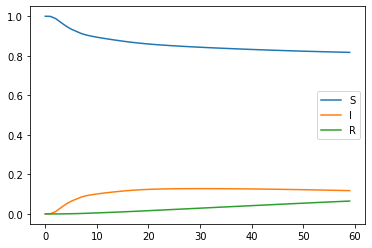

In [444]:
plt.plot(susceptible_pop_norm, label='S')
plt.plot(infected_pop_norm, label='I')
plt.plot(recovered_pop_norm, label='R')
plt.legend()

In [445]:
agg_df = LK_df.groupby("Meldedatum").sum()
last_week_df = agg_df[agg_df.index >= last_week]
last_week_df

,AnzahlFall,AnzahlTodesfall,TotalAnzahl_BL_G_AG,TotalDeath_BL_G_AG
Meldedatum,,,,
2020-03-13,1317,4,3418,10
2020-03-14,1179,2,3700,10
2020-03-15,837,2,3484,8
2020-03-16,1776,2,5888,10
2020-03-17,2519,5,8316,18
2020-03-18,2689,7,10208,17
2020-03-19,1983,6,8930,16
2020-03-20,964,4,4681,14


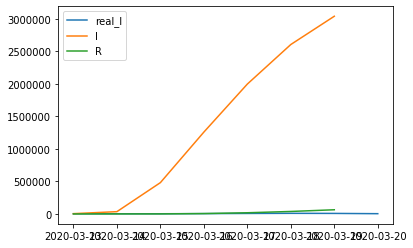

In [447]:
plt.plot(last_week_df.index, "TotalAnzahl_BL_G_AG", data=last_week_df, label="real_I")
plt.plot(np.array(days)[:7], np.array(infected_pop_norm)[:7] * 40617291, label='I')
plt.plot(np.array(days)[:7], np.array(recovered_pop_norm)[:7] * 40617291, label='R')
plt.legend()